In [1]:
# Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
import sys
import json
import os
import glob
import copy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from termcolor import colored
from collections import Counter
import cv2
import tqdm
from termcolor import colored

plt.rcParams["figure.figsize"] = (10,10)

# change this property
NOMEROFF_NET_DIR = os.path.abspath('/var/www/nomeroff-net')
sys.path.append(NOMEROFF_NET_DIR)

In [3]:
from NomeroffNet.BBoxNpPoints import (NpPointsCraft, 
                                      getCvZoneRGB, 
                                      convertCvZonesRGBtoBGR, 
                                      reshapePoints)
from NomeroffNet.YoloV5Detector import Detector
from NomeroffNet.OptionsDetector import OptionsDetector
from NomeroffNet.TextDetector import TextDetector
from NomeroffNet.TextPostprocessings.translit import translit_cyrillic_to_latin

/usr/local/lib64/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
class MaskDatasetChecker:
    def __init__(self):
        self.npPointsCraft = NpPointsCraft()
        self.npPointsCraft.load()
        self.detector = Detector()
        self.detector.load()
        self.optionsDetector = OptionsDetector()
        self.optionsDetector.load()
        self.textDetector = TextDetector()
        self.dataset = {}
        
    def load_dataset(self, json_path):
        dataset = {}
        print("Loading dataset...")
        with open(json_path) as json_file:
            data = json.load(json_file)
            for p in tqdm.tqdm(data['_via_img_metadata']):
                item = data['_via_img_metadata'][p]
                filename = item["filename"]
                bboxes = []
                for region in item['regions']:
                    x1 = min(region['shape_attributes']['all_points_x'])
                    x2 = max(region['shape_attributes']['all_points_x'])
                    y1 = min(region['shape_attributes']['all_points_y'])
                    y2 = max(region['shape_attributes']['all_points_y'])
                    bboxes.append({
                        'x1': x1, 
                        'x2': x2, 
                        'y1': y1, 
                        'y2': y2, 
                        'region_name': region['region_attributes']["region_name"].strip(),
                        'numberplate': region['region_attributes']["np"].strip(),
                    })
                dataset[filename] = bboxes
        self.dataset = dataset
    
    def predict(self, image_paths, debug=1):
        predicted = {}
        print("Predicting...")
        
        counter = Counter()
        for img_path in tqdm.tqdm(image_paths):
            img = mpimg.imread(img_path)
            
            try:
                targetBoxes = self.detector.detect_bbox(copy.deepcopy(img))
                targetBoxes = targetBoxes

                all_points, all_properties = self.npPointsCraft.detect(img, targetBoxes, return_properties=True)
                all_points = [ps for ps in all_points if len(ps)]

                 # cut zones
                toShowZones = [getCvZoneRGB(img, reshapePoints(rect, 1)) for rect in all_points]
                zones = convertCvZonesRGBtoBGR(toShowZones)

                # find standart
                region_ids, countLines = self.optionsDetector.predict(zones)
                region_names = self.optionsDetector.getRegionLabels(region_ids)

                # convert multiline to one line
                zones = self.npPointsCraft.multiline_to_one_line(zones, 
                                                                 all_points, 
                                                                 all_properties, 
                                                                 region_names)

                # find text with postprocessing by standart  
                textArr = self.textDetector.predict(zones, region_names, countLines)

                # append to predicted
                predicted[os.path.basename(img_path)] = []
                for numberplate, points, region_name in zip(textArr, all_points, region_names):
                    predicted[os.path.basename(img_path)].append({
                        'x1': points[0], 
                        'x2': points[2], 
                        'y1': points[1], 
                        'y2': points[3], 
                        'region_name': region_name.strip(),
                        'numberplate': numberplate.strip(),
                    })

                # dispaly debug info
                if debug:
                    dataset_info = self.dataset.get(os.path.basename(img_path), [])
                    trues = [translit_cyrillic_to_latin(np["numberplate"]) 
                                           if np["region_name"] != "su" else  np["numberplate"]
                                           for np in dataset_info]
                    plt.imshow(img)
                    plt.show()
                    print(img_path, colored(trues, "blue"))
                    for zone, numberplate, points, region_name in zip(convertCvZonesRGBtoBGR(zones), 
                                                                      textArr, 
                                                                      all_points, 
                                                                      region_names):
                        color = "yellow"
                        if numberplate in trues:
                            counter["good"] += 1
                            color = "green"
                        else:
                            counter["bad"] += 1

                        plt.imshow(zone)
                        plt.show()
                        print(colored(json.dumps({
                            'region_name': region_name.strip(),
                            'numberplate': numberplate.strip(),
                        }), color))
            except Exception as e:
                print(colored(f"[ERROR] {e}", 'red'))
        
        if debug:             
            print(colored(str(counter), 'blue'))
        return predicted
    
    def compare(self, 
                photo_dir = os.path.join(NOMEROFF_NET_DIR, 'dataset/np/'),
                json_path = os.path.join(NOMEROFF_NET_DIR, 'dataset/np/via.json'),
                iou_less_than = 0.9,
                ocr_acc_less_than = 0.7,
                option_acc_less_than = 0.7,
                mask_acc_less_than = 0.7):
        """
        TODO: add more comparisons
        """         
        self.load_dataset(json_path)
        image_paths = [os.path.join(photo_dir, image_name) for image_name in self.dataset]
        self.predict(image_paths)

In [5]:
maskDatasetChecker = MaskDatasetChecker()

Loading weights of refiner from checkpoint (/mnt/data/var/www/nomeroff-net/NomeroffNet/Base/mcm/./models/NpPointsCraft/refiner/craft_refiner_CTW1500_2020-02-16.pth )
Fusing layers... 


In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

  0%|          | 0/102 [00:00<?, ?it/s]

Loading dataset...
Predicting...


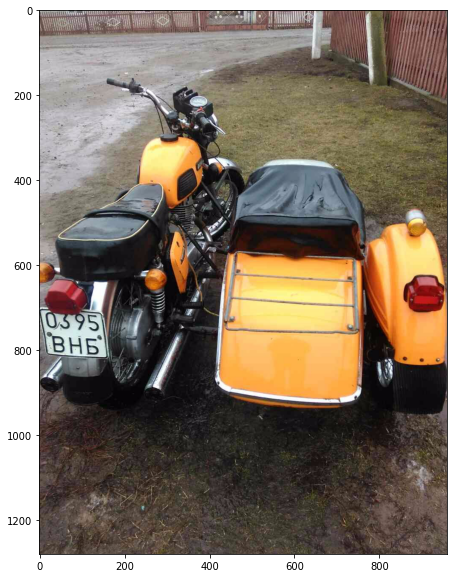

/home/dmitroprobachay/Documents/many_line_images/many_line/195715304.jpeg ['0395ВНБ']


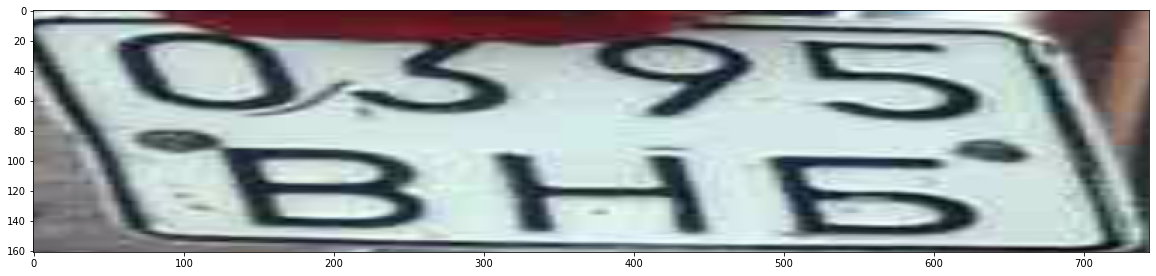

  1%|          | 1/102 [00:02<04:47,  2.85s/it]

{"region_name": "kz", "numberplate": "LZE"}


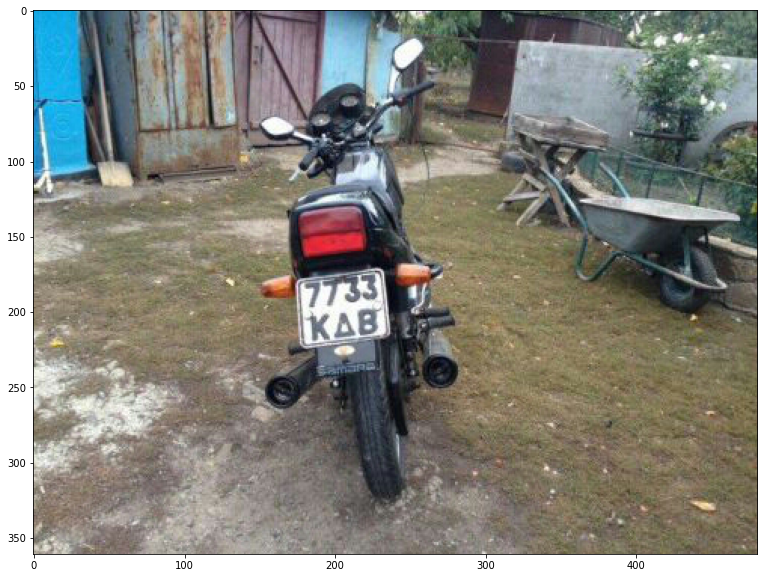

/home/dmitroprobachay/Documents/many_line_images/many_line/205676925.jpeg ['7733КДВ']


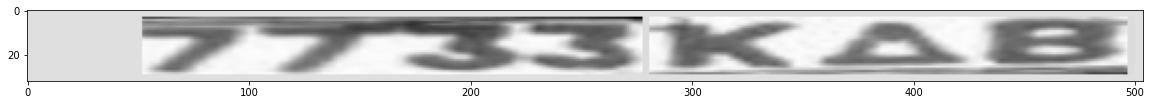

  2%|▏         | 2/102 [00:03<03:52,  2.33s/it]

{"region_name": "xx_unknown", "numberplate": "7733KAB"}


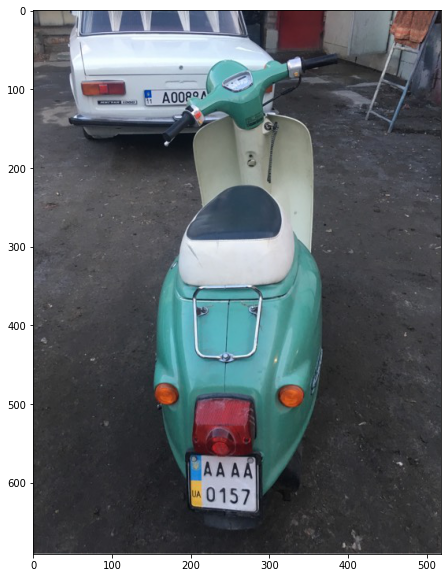

/home/dmitroprobachay/Documents/many_line_images/many_line/213652557.jpeg ['AA0157AA']


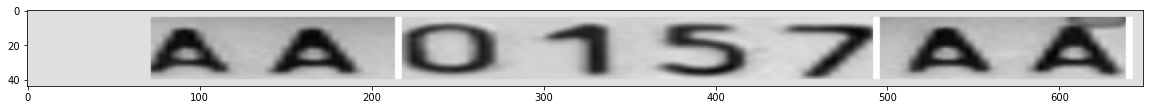

{"region_name": "eu_ua_2004", "numberplate": "AA0157AA"}


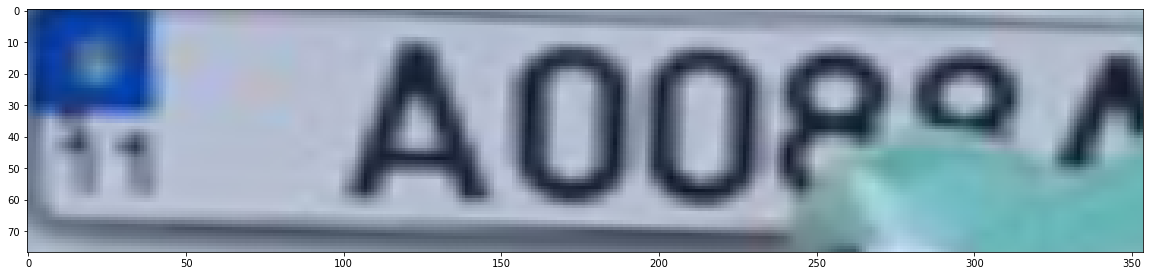

  3%|▎         | 3/102 [00:05<03:33,  2.15s/it]

{"region_name": "eu", "numberplate": "A008R9"}


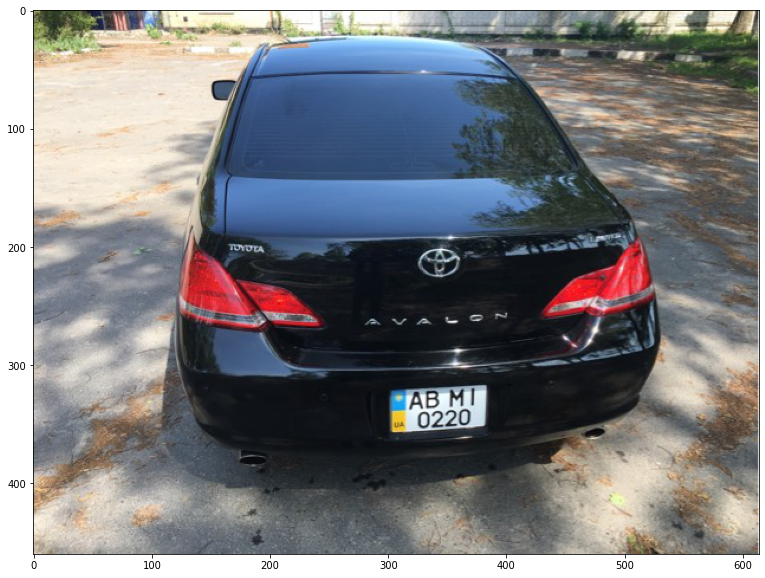

/home/dmitroprobachay/Documents/many_line_images/many_line/235150655.jpeg ['AB0220MI']


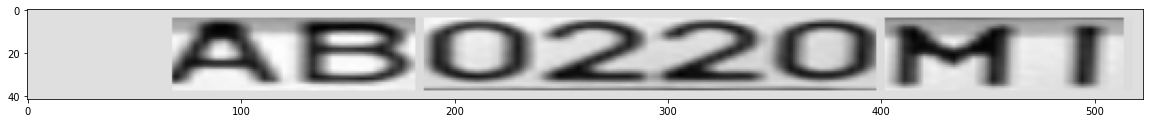

  4%|▍         | 4/102 [00:07<03:08,  1.93s/it]

{"region_name": "eu_ua_2004", "numberplate": "AB0220MI"}


  4%|▍         | 4/102 [00:08<03:32,  2.17s/it]


KeyboardInterrupt: 

In [10]:
maskDatasetChecker.compare(
    photo_dir="/home/dmitroprobachay/Documents/many_line_images/many_line",
    json_path="/home/dmitroprobachay/Downloads/many_line_1new.json"
)

In [9]:
23/(64+23)

0.26436781609195403